### Beer Fermentation PINN with DO & pH

In [1]:
# Python dependencies # Standard libraries
import os      # Operating system interfaces (file paths, directories)
import time    # Time-related functions
import math    # Mathematical functions
import json    # For handling JSON data

# Data handling and plotting
import numpy as np             # Numerical computing
import pandas as pd            # Data manipulation
import matplotlib.pyplot as plt # Plotting and visualization

# PyTorch libraries for deep learning
import torch
import torch.nn as nn          # Neural network modules
import torch.nn.functional as F # Activation functions and other functional ops
from torch.autograd import grad # For computing gradients (useful in PINNs or custom losses)

In [2]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


In [3]:
# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# Load dataset
file_path = "data/02 - IPA - SA-05.csv"  # Fermentation Dataset
df = pd.read_csv(file_path)

# Display info
print("First 5 rows:\n", df.head())
print("\nLast 5 rows:\n", df.tail())
print("\nColumns:\n", df.columns)
print("\nDataset shape:", df.shape)

First 5 rows:
        Timestamp (BST)  Hours from Pitch  DO (mg/L)    pH  Gravity (°P)  \
0  2022-06-17 16:00:00              0.01       1.72  5.77          12.0   
1  2022-06-17 16:10:00              0.18       1.69  5.76          12.0   
2  2022-06-17 16:20:00              0.35       1.70  5.76          12.0   
3  2022-06-17 16:30:00              0.52       1.60  5.76          12.0   
4  2022-06-17 16:40:00              0.68       1.54  5.76          12.0   

   Pressure (Bar)  Fluid Temp (°C)  Ambient Temp (°C)  Conductivity (uS/cm)  
0            0.07             22.4               20.0                2418.0  
1            0.07             22.2               20.0                2424.0  
2            0.07             22.1               20.0                2427.0  
3            0.07             22.1               19.0                2424.0  
4            0.07             22.1               19.0                2427.0  

Last 5 rows:
           Timestamp (BST)  Hours from Pitch  DO (mg

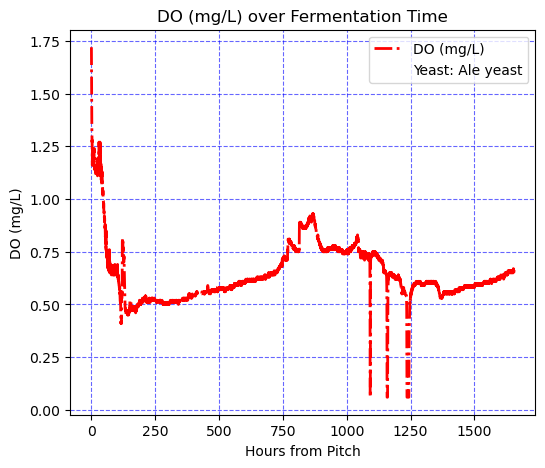

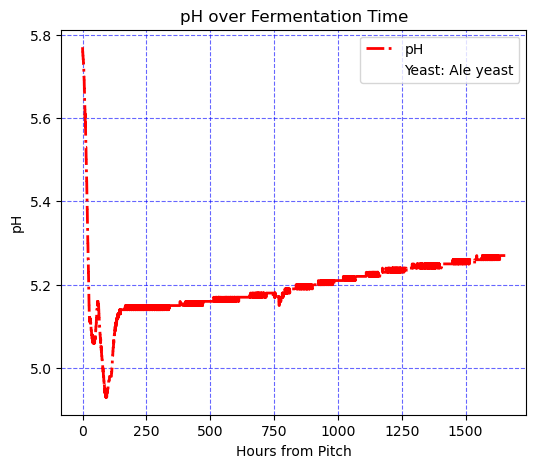

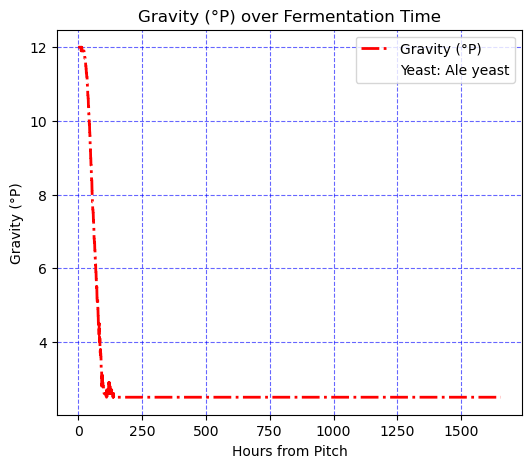

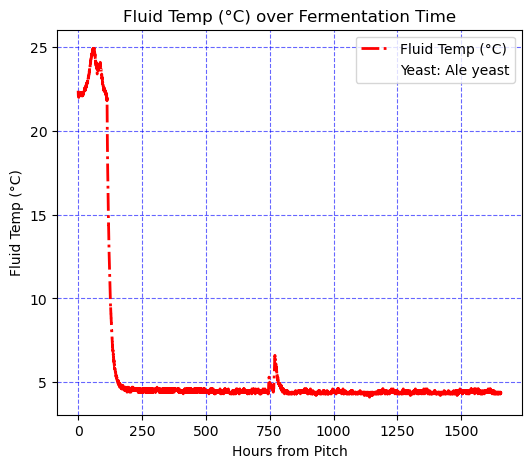

In [5]:
# Convert timestamp to datetime
df["Timestamp (BST)"] = pd.to_datetime(df["Timestamp (BST)"])

# Fermentation variables ["DO (mg/L)", "pH", "Gravity (°P)", "Fluid Temp (°C)"]
variables = ["DO (mg/L)", "pH", "Gravity (°P)", "Fluid Temp (°C)"]

# Yeast type
yeast_type = "Ale yeast"

# Plots | Figures
for var in variables:
    plt.figure(figsize=(6, 5))
    
    # Main variable line
    plt.plot(df["Hours from Pitch"], df[var], label=var, linewidth=2, color="red", linestyle="-.")
    
    # Add yeast type as a legend entry (invisible plot)
    plt.plot([], [], ' ', label=f"Yeast: {yeast_type}")
    
    plt.xlabel("Hours from Pitch")
    plt.ylabel(var)
    plt.title(f"{var} over Fermentation Time")
    plt.grid(True, linestyle="--", color="blue", alpha=0.6)
    plt.legend()
    plt.show()


In [6]:
# Hyperparameters |PINN Settings
# Neural network architecture 
layers = [4, 128, 128, 128, 5] # inputs: [t_scaled, T_scaled, DO_scaled, pH_scaled] -> outputs: X, Cs, Ce, DO_pred, pH_pred

# Collocation and training settings
N_f = 3000               # Number of collocation points for ODE residuals
lr = 5e-4                # Learning rate (Adam)
adam_epochs = 5000       # Number of Adam optimizer epochs

# Physics-informed modeling (Haldane + temperature correction)
use_full_haldane = True     # Enable full Haldane inhibition model
Y_e_s_fixed = 0.51          # Ethanol yield [g ethanol / g sugar]

# Temperature-dependent kinetic parameters (Arrhenius)
mu_ref = 0.4                # Reference μ_max [1/h]
K_s_ref = 0.1               # Substrate affinity constant [g/L]
K_i_ref = 50.0              # Substrate inhibition constant [g/L]
T_ref = 30.0                # Reference temperature [°C]
Ea = 5000.0                 # Activation energy [J/mol]
R = 8.314                   # Universal gas constant [J/mol/K]

# Loss function weights
w_data_cs = 10.0    # Measured substrate (from Gravity → Cs)
w_data_do = 10.0    # Measured DO
w_data_ph = 5.0     # Measured pH
w_data_ce = 5.0     # Ethanol estimation
w_phys = 100.0      # Physics (ODE residuals)
w_ic = 100.0        # Initial conditions

# Numerical stability
EPS = 1e-8

In [7]:
# Information about the beer fermentation dataset
df_info = {
    "shape": df.shape,  # Number of rows and columns
    "columns": list(df.columns),  # List of column names
    "dtypes": df.dtypes.apply(lambda x: str(x)).to_dict(),  # Data types for each column
    "head": df.head(8).applymap(lambda x: str(x) if isinstance(x, pd.Timestamp) else x).to_dict(orient="list"),  # Preview first 8 rows
    "nan_counts": df.isna().sum().to_dict()  # Count missing values in each column
}

# Print the information in JSON format for readability
print(json.dumps(df_info, indent=2))

{
  "shape": [
    9933,
    9
  ],
  "columns": [
    "Timestamp (BST)",
    "Hours from Pitch",
    "DO (mg/L)",
    "pH",
    "Gravity (\u00b0P)",
    "Pressure (Bar)",
    "Fluid Temp (\u00b0C)",
    "Ambient Temp (\u00b0C)",
    "Conductivity (uS/cm)"
  ],
  "dtypes": {
    "Timestamp (BST)": "datetime64[ns]",
    "Hours from Pitch": "float64",
    "DO (mg/L)": "float64",
    "pH": "float64",
    "Gravity (\u00b0P)": "float64",
    "Pressure (Bar)": "float64",
    "Fluid Temp (\u00b0C)": "float64",
    "Ambient Temp (\u00b0C)": "float64",
    "Conductivity (uS/cm)": "float64"
  },
  "head": {
    "Timestamp (BST)": [
      "2022-06-17 16:00:00",
      "2022-06-17 16:10:00",
      "2022-06-17 16:20:00",
      "2022-06-17 16:30:00",
      "2022-06-17 16:40:00",
      "2022-06-17 16:50:00",
      "2022-06-17 17:00:00",
      "2022-06-17 17:10:00"
    ],
    "Hours from Pitch": [
      0.01,
      0.18,
      0.35,
      0.52,
      0.68,
      0.85,
      1.02,
      1.18
    ],
    

/var/folders/7q/1pqndbz17fbd8s_b61735x400000gn/T/ipykernel_51448/1581093731.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  "head": df.head(8).applymap(lambda x: str(x) if isinstance(x, pd.Timestamp) else x).to_dict(orient="list"),  # Preview first 8 rows


In [9]:
# Columns in the CSV:
# 'Timestamp (BST)', 'Hours from Pitch', 'DO (mg/L)', 'pH', 
# 'Gravity (°P)', 'Pressure (Bar)', 'Fluid Temp (°C)', 'Ambient Temp (°C)', 'Conductivity (uS/cm)'
t_data = df['Hours from Pitch'].values          # Time (h)
plato = df['Gravity (°P)'].values              # Sugar (Plato)
DO_meas = df['DO (mg/L)'].values               # Dissolved oxygen
pH_meas = df['pH'].values                       # pH
temp = df['Fluid Temp (°C)'].values            # Temperature

In [10]:
# Plato to Sugar Concentration Conversion (g/L) 
def plato_to_concentration(P):
    """
    Convert Plato (°P) to sugar concentration (g/L) using an empirical density polynomial.
    Parameters:
        P (float or np.array): Plato value(s)
    Returns:
        Cs (float or np.array): Sugar concentration in g/L
    """
    # Density of wort in g/mL (empirical polynomial fit)
    rho = 1 + 0.003867 * P + 0.00001243 * P**2 + 0.000000013 * P**3
    
    # Convert to sugar concentration (g/L)
    Cs = (P / 100.0) * rho * 1000.0
    return Cs

# Apply conversion to your dataset
Cs_data = plato_to_concentration(plato)

# First 5 sugar concentrations
print("First 5 sugar concentrations (g/L):", Cs_data[:5])


First 5 sugar concentrations (g/L): [125.78596608 125.78596608 125.78596608 125.78596608 125.78596608]


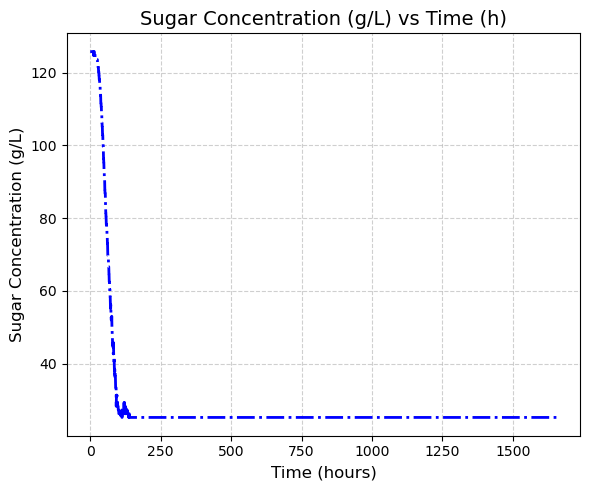

In [11]:
# Plot Sugar Concentration Over Time 
plt.figure(figsize=(6, 5))
plt.plot(t_data, Cs_data, linewidth=2, color="blue", linestyle="-.")

plt.xlabel("Time (hours)", fontsize=12)
plt.ylabel("Sugar Concentration (g/L)", fontsize=12)
plt.title("Sugar Concentration (g/L) vs Time (h)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Plato → ethanol concentration (g/L)

In [12]:
def plato_to_abv(P, P0):
    """
    Estimate ABV (%) from Plato drop.
    Parameters:
        P  (float or np.array): Current Plato
        P0 (float): Initial Plato
    Returns:
        ABV (float or np.array): Alcohol by volume in %
    """
    ABV = (P0 - P) * 0.131
    ABV[ABV < 0] = 0
    return ABV


In [13]:
def abv_to_ethanol(ABV):
    """
    Convert ABV (%) to ethanol concentration (g/L).
    """
    Ce = ABV * 7.89
    return Ce


In [14]:
def plato_to_ethanol(P, P0):
    """
    Convert current Plato to ethanol concentration (g/L)
    based on initial Plato and empirical ABV conversion.
    """
    ABV = plato_to_abv(P, P0)
    Ce = abv_to_ethanol(ABV)
    return Ce


In [15]:
P0 = plato[0]  # initial Plato (original gravity)
Ce_data = plato_to_ethanol(plato, P0)

print("First 5 ethanol concentrations (g/L):", Ce_data[:5])


First 5 ethanol concentrations (g/L): [0. 0. 0. 0. 0.]


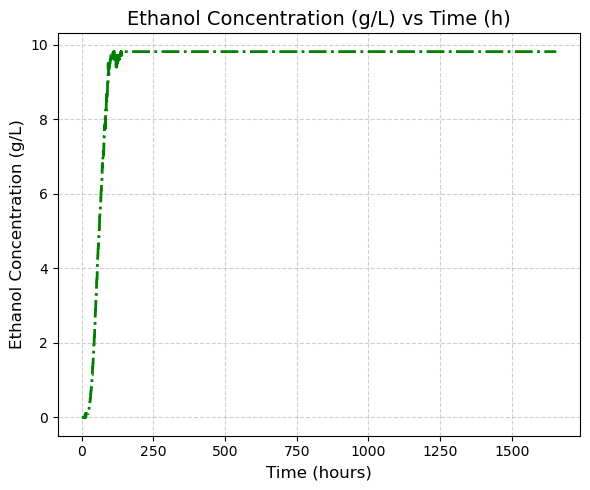

In [23]:
# Plot Ethanol Concentration
plt.figure(figsize=(6, 5))
plt.plot(t_data, Ce_data, linewidth=2, color="green", linestyle="-.")
plt.xlabel("Time (hours)", fontsize=12)
plt.ylabel("Ethanol Concentration (g/L)", fontsize=12)
plt.title("Ethanol Concentration (g/L) vs Time (h)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [24]:
# t_min = The starting time of fermentation 
# t_max = The final time of fermentation
t_min, t_max = float(np.min(t_data)), float(np.max(t_data))

print(f"Physical Time Range: {t_min:.2f} h to {t_max:.2f} h")
print(f"Total Fermentation Time: {t_max - t_min:.2f} h")

Physical Time Range: 0.01 h to 1655.47 h
Total Fermentation Time: 1655.46 h


In [25]:
# Define scaling functions
t_min, t_max = float(np.min(t_data)), float(np.max(t_data))

def scale_time(arr):
    return (np.asarray(arr) - t_min) / (t_max - t_min + 1e-12)

def scale_temp(arr):
    a = np.asarray(arr).reshape(-1)
    return (a - np.mean(a)) / (np.max(a) - np.min(a) + 1e-12)

def scale_standard(arr):
    a = np.asarray(arr).reshape(-1)
    return (a - np.mean(a)) / (np.std(a) + 1e-12)

In [37]:
# Rescale time back to physical hours
def unscale_time(arr_scaled):
    return arr_scaled * (t_max - t_min) + t_min

In [26]:
# Scale the variables 
t_scaled = scale_time(t_data).reshape(-1, 1)
T_scaled = scale_temp(temp).reshape(-1, 1)
DO_scaled = scale_standard(DO_meas).reshape(-1, 1)
PH_scaled = scale_standard(pH_meas).reshape(-1, 1)
plato_scaled = scale_standard(plato).reshape(-1, 1)

In [27]:
# Convert to PyTorch tensors
t_Cs_tensor = torch.tensor(t_scaled, dtype=torch.float32, device=DEVICE, requires_grad=True)
T_input_tensor = torch.tensor(T_scaled, dtype=torch.float32, device=DEVICE)
DO_scaled_tensor = torch.tensor(DO_scaled, dtype=torch.float32, device=DEVICE)
PH_scaled_tensor = torch.tensor(PH_scaled, dtype=torch.float32, device=DEVICE)

Cs_obs_tensor = torch.tensor(plato_scaled, dtype=torch.float32, device=DEVICE)
DO_obs_scaled_tensor = torch.tensor(DO_scaled, dtype=torch.float32, device=DEVICE)
PH_obs_scaled_tensor = torch.tensor(PH_scaled, dtype=torch.float32, device=DEVICE)

In [28]:
# Initial conditions 
X0 = 0.1
Cs0 = float(plato[0])
Ce0 = 0.0
DO0 = float(DO_meas[0])
pH0 = float(pH_meas[0])

In [29]:
# FermentationPINN Class
class FermentationPINN(nn.Module):
    def __init__(self, layers):
        super(FermentationPINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

        # Learnable physical parameters (initial guesses)
        self.mu_ref = nn.Parameter(torch.tensor(mu_ref, dtype=torch.float32, device=DEVICE))
        self.Ks = nn.Parameter(torch.tensor(K_s_ref, dtype=torch.float32, device=DEVICE))
        self.Ki = nn.Parameter(torch.tensor(K_i_ref, dtype=torch.float32, device=DEVICE))
        self.Y_xs = nn.Parameter(torch.tensor(0.5, dtype=torch.float32, device=DEVICE))  # Biomass yield
        self.kLa = nn.Parameter(torch.tensor(0.1, dtype=torch.float32, device=DEVICE))
        self.YxO2 = nn.Parameter(torch.tensor(0.5, dtype=torch.float32, device=DEVICE))
        self.kph = nn.Parameter(torch.tensor(0.1, dtype=torch.float32, device=DEVICE))
        self.Q10 = nn.Parameter(torch.tensor(1.5, dtype=torch.float32, device=DEVICE))
        self.L = nn.Parameter(torch.tensor(0.1, dtype=torch.float32, device=DEVICE))  # lag term
        self.ki_eth = nn.Parameter(torch.tensor(50.0, dtype=torch.float32, device=DEVICE))  # ethanol inhibition

    def forward(self, t, T, DO, pH):
        # Concatenate inputs: t, T, DO, pH
        X = torch.cat([t, T, DO, pH], dim=1)
        for i in range(len(self.layers)-1):
            X = self.activation(self.layers[i](X))
        out = self.layers[-1](X)
        X_pred = out[:,0:1]
        Cs_pred = out[:,1:2]
        Ce_pred = out[:,2:3]
        DO_pred = out[:,3:4]
        pH_pred = out[:,4:5]
        return X_pred, Cs_pred, Ce_pred, DO_pred, pH_pred

    def phys_params(self):
        return self.mu_ref, self.Ks, self.ki_eth, self.L, self.Y_xs, self.kLa, self.YxO2, self.kph, self.Q10

    def mu(self, t_phys, Cs, Ce, T):
        """
        Full Haldane growth rate + ethanol inhibition + lag + Q10 temperature correction
        μ(t) = μ_ref * (Cs/(Ks + Cs + Cs^2/Ki)) * exp(-Ce/ki_eth) * Q10^((T-T_ref)/10) * lag(t)
        """
        # Substrate inhibition
        H = Cs / (self.Ks + Cs + Cs**2/self.ki_eth)
        # Ethanol inhibition
        Eth_inh = torch.exp(-Ce / self.ki_eth)
        # Temperature correction
        Q10_corr = self.Q10 ** ((T - T_ref)/10.0)
        # Lag function
        lag_func = 1 - torch.exp(-t_phys/self.L)
        mu_val = self.mu_ref * H * Eth_inh * Q10_corr * lag_func
        return mu_val


In [30]:
# Instantiate the model 
model = FermentationPINN(layers).to(DEVICE)

In [32]:
# Loss Function
def loss_fn(t_Cs_tensor, T_input_tensor, DO_scaled_tensor, PH_scaled_tensor,
            Cs_obs_tensor, DO_obs_scaled_tensor, PH_obs_scaled_tensor,
            t_coll_scaled, T_coll_scaled):
    
    # ---- Forward pass on measured data ----
    Xp_all, Csp_all, Cep_all, DO_pred_all, pH_pred_all = model(
        t_Cs_tensor, T_input_tensor, DO_scaled_tensor, PH_scaled_tensor
    )

    # ---- Data losses ----
    data_loss_cs = F.mse_loss(Csp_all, Cs_obs_tensor)
    data_loss_do = F.mse_loss(DO_pred_all, DO_obs_scaled_tensor)
    data_loss_ph = F.mse_loss(pH_pred_all, PH_obs_scaled_tensor)

    # ---- Physics residuals ----
    Xc, Csc, Cec, DOc, pHc = model(t_coll_scaled, T_coll_scaled, DO_scaled_tensor[:t_coll_scaled.shape[0]], PH_scaled_tensor[:t_coll_scaled.shape[0]])
    
    dXdt = torch.autograd.grad(Xc, t_coll_scaled, grad_outputs=torch.ones_like(Xc), retain_graph=True, create_graph=True)[0]
    dCsdt = torch.autograd.grad(Csc, t_coll_scaled, grad_outputs=torch.ones_like(Csc), retain_graph=True, create_graph=True)[0]
    dCedt = torch.autograd.grad(Cec, t_coll_scaled, grad_outputs=torch.ones_like(Cec), retain_graph=True, create_graph=True)[0]
    dDOdt = torch.autograd.grad(DOc, t_coll_scaled, grad_outputs=torch.ones_like(DOc), retain_graph=True, create_graph=True)[0]
    dpHdt = torch.autograd.grad(pHc, t_coll_scaled, grad_outputs=torch.ones_like(pHc), retain_graph=True, create_graph=True)[0]

    # ---- Growth rate ----
    t_phys = t_coll_scaled * (t_max - t_min) + t_min  # unscale time
    mu_pred = model.mu(t_phys, Csc, Cec, T_coll_scaled)

    # ---- ODE residuals ----
    DO_sat = 8.0
    rX = dXdt - mu_pred * Xc
    rCs = dCsdt + (1.0 / (model.Y_xs + EPS)) * mu_pred * Xc
    rCe = dCedt - (Y_e_s_fixed / (model.Y_xs + EPS)) * mu_pred * Xc
    rDO = dDOdt - (model.kLa * (DO_sat - DOc) - (1.0 / (model.YxO2 + EPS)) * dXdt)
    rPH = dpHdt + model.kph * (pHc - 4.2)

    phys_loss = rX.pow(2).mean() + rCs.pow(2).mean() + rCe.pow(2).mean() + rDO.pow(2).mean() + rPH.pow(2).mean()

    # ---- Initial condition loss ----
    ic_loss = (
        F.mse_loss(Csc[0], Cs_obs_tensor[0]) +
        F.mse_loss(Cec[0], torch.tensor([Ce0], dtype=torch.float32, device=DEVICE)) +
        F.mse_loss(DOc[0], DO_obs_scaled_tensor[0]) +
        F.mse_loss(pHc[0], PH_obs_scaled_tensor[0])
    )

    # ---- Total weighted loss ----
    total_loss = (
        w_data_cs * data_loss_cs +
        w_data_do * data_loss_do +
        w_data_ph * data_loss_ph +
        w_phys * phys_loss +
        w_ic * ic_loss
    )

    return total_loss, data_loss_cs, data_loss_do, data_loss_ph, phys_loss, ic_loss


In [34]:
# Initialize model
model = FermentationPINN(layers).to(DEVICE)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Collocation tensors (randomly sample from scaled time for physics residuals)

T_coll_scaled = torch.tensor(
    np.interp(
        t_coll_scaled.detach().cpu().numpy().flatten(),  # detach to remove grad
        t_scaled.flatten(),
        T_scaled.flatten()
    ),
    dtype=torch.float32,
    device=DEVICE
).reshape(-1, 1)

print("Starting training...")
start_time = time.time()

for ep in range(1, adam_epochs + 1):
    optimizer.zero_grad()

    # Compute total loss and components
    total_loss, dl_cs, dl_do, dl_ph, pl, il = loss_fn(
        t_Cs_tensor, T_input_tensor, DO_scaled_tensor, PH_scaled_tensor,
        Cs_obs_tensor, DO_obs_scaled_tensor, PH_obs_scaled_tensor,
        t_coll_scaled, T_coll_scaled
    )

    # Backpropagation
    total_loss.backward()

    # Gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)

    # Optimizer step
    optimizer.step()

    # Logging every ~10% of epochs
    if ep % max(1, adam_epochs // 10) == 0 or ep == 1:
        mu_ref_val, Ks_val, ki_eth_val, L_val, Y_xs_val, kLa_val, YxO2_val, kph_val, Q10_val = model.phys_params()
        print(f"Epoch {ep}/{adam_epochs} | Total Loss={total_loss.item():.6f} | "
              f"Data: Cs={dl_cs.item():.6f}, DO={dl_do.item():.6f}, pH={dl_ph.item():.6f} | "
              f"Phys={pl.item():.6f}, IC={il.item():.6f}")
        print(f"Params: mu_ref={mu_ref_val.item():.4f}, Ks={Ks_val.item():.4f}, ki_eth={ki_eth_val.item():.4f}, "
              f"L={L_val.item():.4f}, Y_xs={Y_xs_val.item():.4f}, kLa={kLa_val.item():.4f}, "
              f"YxO2={YxO2_val.item():.4f}, kph={kph_val.item():.4f}, Q10={Q10_val.item():.4f}")

end_time = time.time()
print(f"Training done in {end_time - start_time:.1f} seconds")


Starting training...
Epoch 1/5000 | Total Loss=14993.590820 | Data: Cs=0.929837, DO=1.058513, pH=1.104524 | Phys=1.377044, IC=148.304810
Params: mu_ref=0.3995, Ks=0.0995, ki_eth=50.0005, L=0.1001, Y_xs=0.5005, kLa=0.0995, YxO2=0.5005, kph=0.0995, Q10=1.5005
Epoch 500/5000 | Total Loss=10.250467 | Data: Cs=0.319155, DO=0.145256, pH=0.088345 | Phys=0.051252, IC=0.000395
Params: mu_ref=0.2588, Ks=0.0948, ki_eth=49.9361, L=0.0962, Y_xs=0.6263, kLa=0.0205, YxO2=0.4037, kph=0.0374, Q10=1.6292
Epoch 1000/5000 | Total Loss=2.018124 | Data: Cs=0.086729, DO=0.023948, pH=0.041217 | Phys=0.004952, IC=0.002100
Params: mu_ref=0.1595, Ks=0.0914, ki_eth=49.8854, L=0.0941, Y_xs=0.6724, kLa=0.0209, YxO2=0.3316, kph=0.0225, Q10=1.6933
Epoch 1500/5000 | Total Loss=0.817127 | Data: Cs=0.031818, DO=0.011436, pH=0.031498 | Phys=0.001028, IC=0.001243
Params: mu_ref=0.0963, Ks=0.0912, ki_eth=49.8774, L=0.0940, Y_xs=0.6892, kLa=0.0196, YxO2=0.2859, kph=0.0176, Q10=1.7193
Epoch 2000/5000 | Total Loss=1.656312 | 

In [39]:
# ===== 1. Ensure unscale_time is defined =====
def unscale_time(arr_scaled):
    return arr_scaled * (t_max - t_min) + t_min

In [40]:
# ===== 2. Get model predictions =====
model.eval()  # set model to evaluation mode
with torch.no_grad():
    X_pred, Cs_pred, Ce_pred, DO_pred, pH_pred = model(
        t_Cs_tensor, T_input_tensor, DO_scaled_tensor, PH_scaled_tensor
    )

In [41]:
# ===== 3. Convert to numpy for plotting =====
t_phys = unscale_time(t_Cs_tensor.detach().cpu().numpy()).flatten()
Cs_pred_np = Cs_pred.detach().cpu().numpy().flatten()
Ce_pred_np = Ce_pred.detach().cpu().numpy().flatten()
DO_pred_np = DO_pred.detach().cpu().numpy().flatten()
pH_pred_np = pH_pred.detach().cpu().numpy().flatten()

Cs_obs_np = Cs_obs_tensor.detach().cpu().numpy().flatten()
DO_obs_np = DO_obs_scaled_tensor.detach().cpu().numpy().flatten()
PH_obs_np = PH_obs_scaled_tensor.detach().cpu().numpy().flatten()

### Plot predictions vs measured 

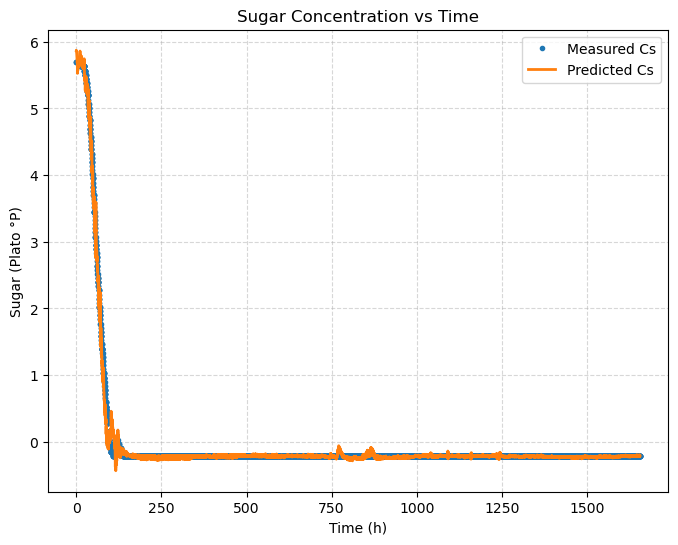

In [59]:
# Sugar (Cs)
plt.figure(figsize=(8, 6))
plt.plot(t_phys, Cs_obs_np, 'o', label='Measured Cs', markersize=3)
plt.plot(t_phys, Cs_pred_np, '-', label='Predicted Cs', linewidth=2)
plt.xlabel("Time (h)")
plt.ylabel("Sugar (Plato °P)")
plt.title("Sugar Concentration vs Time")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)


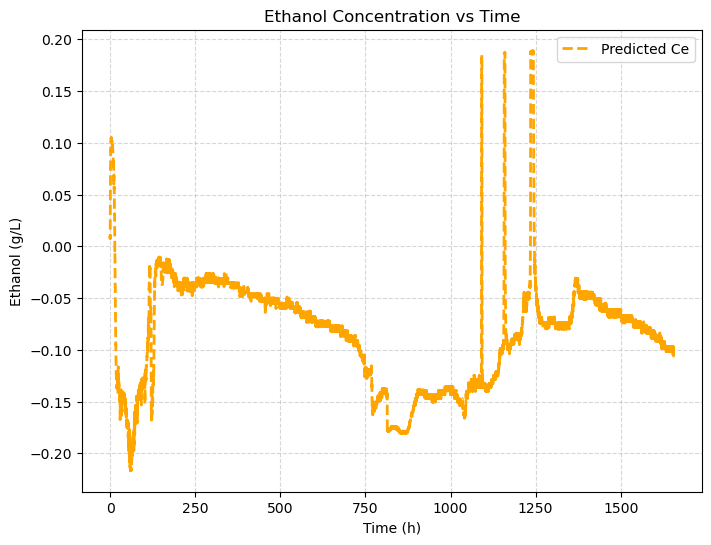

In [ ]:
# Ethanol (Ce)
plt.figure(figsize=(8, 6))
plt.plot(t_phys, Ce_pred_np, '--', label='Predicted Ce', color='orange', linewidth=2)
plt.xlabel("Time (h)")
plt.ylabel("Ethanol (g/L)")
plt.title("Ethanol Concentration vs Time")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

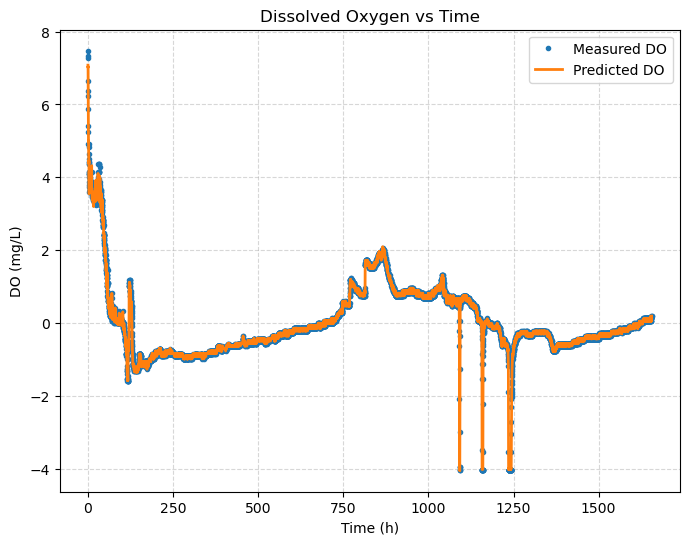

In [63]:
# Dissolved Oxygen (DO)
plt.figure(figsize=(8, 6))
plt.plot(t_phys, DO_obs_np, 'o', label='Measured DO', markersize=3)
plt.plot(t_phys, DO_pred_np, '-', label='Predicted DO', linewidth=2)
plt.xlabel("Time (h)")
plt.ylabel("DO (mg/L)")
plt.title("Dissolved Oxygen vs Time")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

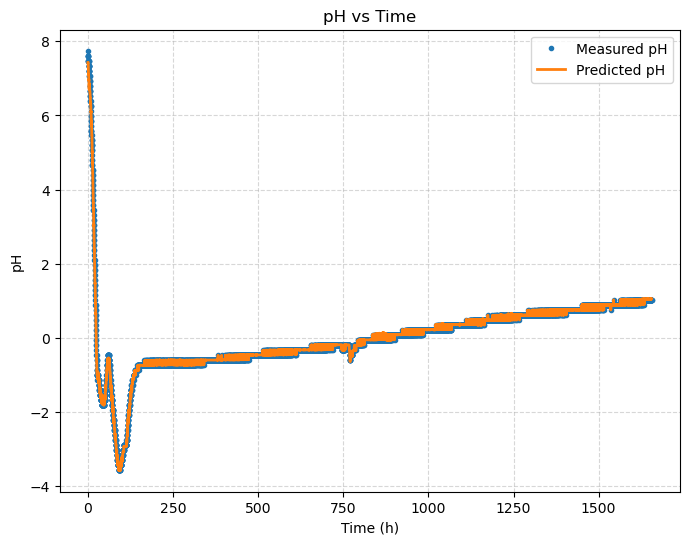

In [ ]:
# pH
plt.plot(t_phys, PH_obs_np, 'o', label='Measured pH', markersize=3)
plt.plot(t_phys, pH_pred_np, '-', label='Predicted pH', linewidth=2)
plt.xlabel("Time (h)")
plt.ylabel("pH")
plt.title("pH vs Time")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

In [65]:
# Run model on training time to get predictions
model.eval()
with torch.no_grad():
    X_pred, Cs_pred, Ce_pred, DO_pred, pH_pred = model(
        t_Cs_tensor, T_input_tensor, DO_scaled_tensor, PH_scaled_tensor
    )

# Convert to NumPy for plotting
X_pred_np = X_pred.detach().cpu().numpy().flatten()
Cs_pred_np = Cs_pred.detach().cpu().numpy().flatten()
Ce_pred_np = Ce_pred.detach().cpu().numpy().flatten()
DO_pred_np = DO_pred.detach().cpu().numpy().flatten()
pH_pred_np = pH_pred.detach().cpu().numpy().flatten()

# Observed values
Cs_obs_np = Cs_obs_tensor.detach().cpu().numpy().flatten()
DO_obs_np = DO_obs_scaled_tensor.detach().cpu().numpy().flatten()
PH_obs_np = PH_obs_scaled_tensor.detach().cpu().numpy().flatten()

# Physical time (unscaled)
t_phys = unscale_time(t_scaled.flatten())


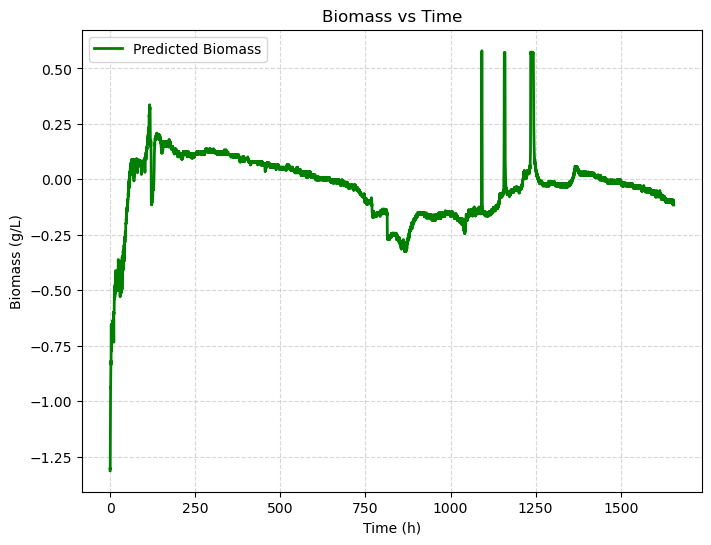

In [67]:
# Biomass (X)
plt.figure(figsize=(8, 6))
plt.plot(t_phys, X_pred_np, '-', label='Predicted Biomass', color='green', linewidth=2)
plt.xlabel("Time (h)")
plt.ylabel("Biomass (g/L)")
plt.title("Biomass vs Time")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

In [68]:
# Retrieve learned physical parameters after training
mu_ref_val, Ks_val, ki_eth_val, L_val, Y_xs_val, kLa_val, YxO2_val, kph_val, Q10_val = model.phys_params()

# Print in a formatted table
print("\n=== Learned Physical Parameters ===")
print(f"μ_ref        (max specific growth rate)          : {mu_ref_val.item():.5f}  1/h")
print(f"K_s          (substrate affinity constant)       : {Ks_val.item():.5f}  g/L")
print(f"K_i_eth      (ethanol inhibition constant)      : {ki_eth_val.item():.5f}  g/L")
print(f"L            (lag time constant)                : {L_val.item():.5f}  h")
print(f"Y_x/s        (yield of biomass on substrate)    : {Y_xs_val.item():.5f}  g/g")
print(f"kLa          (mass transfer coefficient)       : {kLa_val.item():.5f}  1/h")
print(f"Y_x/O2       (yield of biomass on oxygen)      : {YxO2_val.item():.5f}  g/g")
print(f"k_pH         (pH decay rate constant)         : {kph_val.item():.5f}  1/h")
print(f"Q10          (temperature correction factor)   : {Q10_val.item():.5f}")



=== Learned Physical Parameters ===
μ_ref        (max specific growth rate)          : -0.00010  1/h
K_s          (substrate affinity constant)       : 0.10853  g/L
K_i_eth      (ethanol inhibition constant)      : 49.86730  g/L
L            (lag time constant)                : 0.09027  h
Y_x/s        (yield of biomass on substrate)    : 0.70327  g/g
kLa          (mass transfer coefficient)       : 0.00763  1/h
Y_x/O2       (yield of biomass on oxygen)      : 0.19820  g/g
k_pH         (pH decay rate constant)         : 0.00700  1/h
Q10          (temperature correction factor)   : 1.74052
